First, prepare parameters and load the tx data

/mnt/class_data/esnyder/raw_data/svalbard_full/20220822_091437.h5


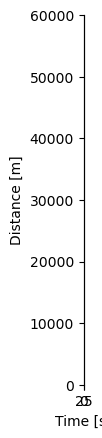

In [7]:
# Verify labels work using matplotlib
import data_io as io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.signal as sp
import os
from IPython.display import display

label_file = r'/home/Eric/Documents/gitRepos/cv4e_dataPrep/fx_labels_Bp.csv'
tx_label_file = r'/home/Eric/Documents/gitRepos/cv4e_dataPrep/tx_labels_Bp.csv'
data_path = r'/mnt/class_data/esnyder/raw_data'
labels = pd.read_csv(label_file)
tx_labels = pd.read_csv(tx_label_file)

# Pick a random label row
row = labels.iloc[np.random.randint(0, len(labels))]
data_filepath = os.path.join(data_path, row['dataset'], row['source_file'])
print(data_filepath)

# Find all labels in same dataset & time
same_labels = labels[
    (labels['source_file'] == row['source_file']) &
    (labels['t'] == row['t'])
]

# load and extract settings 
settings_file = io.find_settings_h5(data_filepath)
settings = io.load_settings_preprocessed_h5(settings_file)
nonzeros = settings['rehydration_info']['nonzeros_mask']
original_shape = settings['rehydration_info']['target_shape']
dx = settings['processing_settings']['dx']
fs = settings['processing_settings']['fs']

# create dictionary to map source file to start time
file_to_timestamp = {item[1]: item[0] for item in settings['file_map']}
file_start_time = file_to_timestamp[row['source_file']]

# load preprocessed data
fk_dehyd, timestamp = io.load_preprocessed_h5(data_filepath)

# Rehydrate
tx = 1e9 * io.rehydrate(fk_dehyd, nonzeros, original_shape, return_format='tx')

# define axes extents:
x_extent = tx.shape[0]*dx
t_extent = tx.shape[1]/fs

# find labels that correspond to this data slice
tx_same_labels = tx_labels[
    (tx_labels['source_file'] == row['source_file']) &
    (tx_labels['dataset'] == row['dataset']) 
]

# print(tx_same_labels)
fig = plt.figure()
# extent = [x_min, x_max, y_min, y_max] for imshow
extent = [0, t_extent, 0, x_extent]
plt.imshow(tx, extent=extent, origin='lower', vmin = 0, vmax=.3)
plt.xlabel('Time [s]')
plt.ylabel('Distance [m]')
# overlay bounding boxes for each label

for i, tx_row in tx_same_labels.iterrows():
    t_min = tx_row['t_start_s'] + tx_row['apex_time'] - file_start_time
    dt = tx_row['t_end_s'] - tx_row['t_start_s']
    x_min = tx_row['x_min_m']
    dx = tx_row['x_max_m'] - tx_row['x_min_m']
    rect = plt.Rectangle((t_min, x_min), dt, dx, linewidth=2, edgecolor='r', facecolor='none')
    plt.gca().add_patch(rect)
plt.show()


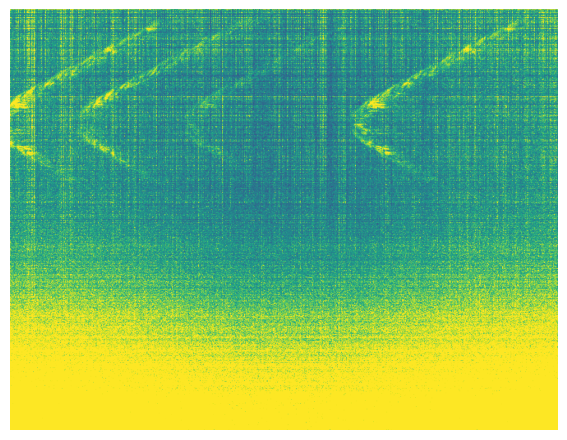

tx_row['apex_time']=1661159695.66
file_start_time=np.float64(1661159677.0)
5.376
181.944
---
7.224
160.832
---
1.288
179.984
---


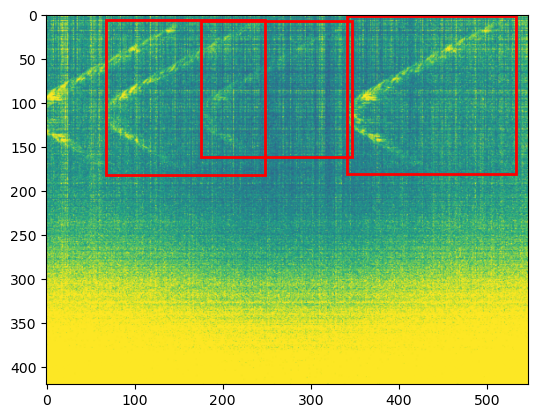

In [8]:
from skimage.measure import block_reduce
import numpy as np
import matplotlib.image as im


# max pool using scikit-image
reduction_factor = tx.shape[1]//640
k_h = tx.shape[0]//reduction_factor
k_w = tx.shape[1]//reduction_factor
tx_downsampled = block_reduce(np.abs(tx), block_size=(reduction_factor, reduction_factor), func=np.max)

# tx_downsampled = adaptive_max_pool_2d(tx, out_h=640, out_w=640, pad_if_smaller=True)
fig = plt.figure()

plt.imshow(tx_downsampled, aspect='auto', extent=extent, origin='upper', vmin = 0, vmax=.4)
plt.tight_layout()
plt.axis('off')
fig.savefig("test.png", bbox_inches='tight', pad_inches=0.0)
plt.show()

# load image again (to test mapping labels onto the images)
tx_load = im.imread("test.png")
plt.imshow(tx_load, origin='upper')

# map labels to pixels:
px = tx_load.shape[0]
pt = tx_load.shape[1]

print(f"{tx_row['apex_time']=}")
print(f"{file_start_time=}")

for i, tx_row in tx_same_labels.iterrows():
    t_min = tx_row['t_start_s'] + tx_row['apex_time'] - file_start_time
    t_max = tx_row['t_end_s'] + tx_row['apex_time'] - file_start_time
    x_min = tx_row['x_min_m']
    x_max = tx_row['x_max_m']

    pt_min = pt*t_min/t_extent
    pt_max = pt*t_max/t_extent

    px_min = px*x_min/x_extent
    px_max = px*x_max/x_extent

    print(px_min)
    print(px_max)
    print('---')
    rect = plt.Rectangle((pt_min, px_min), pt_max-pt_min, px_max-px_min, linewidth=2, edgecolor='r', facecolor='none')
    plt.gca().add_patch(rect)
plt.show()
# add labels in pixel space to plot

In [9]:
# Prepare for YOLO formatting
yolo_filepath = r'/mnt/class_data/esnyder/yolo_data_txplots'
os.makedirs(yolo_filepath, exist_ok=True)

# set and create subdirectories:
img_path = os.path.join(yolo_filepath, 'images')
os.makedirs(img_path, exist_ok=True)

labels_path = os.path.join(yolo_filepath, 'labels')
os.makedirs(labels_path, exist_ok=True)

# iterate over every dataset and generate tx plot + labels in YOLO format:
dataset_list = labels['dataset'].unique()
for dataset in dataset_list:
    dataset_path = os.path.join(data_path, dataset) # path to dataset
    
    # load settings file in this path:
    settings_file = os.path.join(dataset_path, 'settings.h5')
    print(settings_file)
    settings = io.load_settings_preprocessed_h5(settings_file)
    nonzeros = settings['rehydration_info']['nonzeros_mask']
    original_shape = settings['rehydration_info']['target_shape']
    dx = settings['processing_settings']['dx']
    fs = settings['processing_settings']['fs']

    # set extents:
    x_extent = original_shape[0]*dx
    t_extent = original_shape[1]/fs

    # iterate over every file in dataset_path:
    for file in os.listdir(dataset_path):
        # skip if not h5 file or if filename contains "settings":
        if not file.endswith('.h5') or 'settings' in file:
            continue
        h5_filepath = os.path.join(dataset_path, file)

        # set file save name:
        png_save_name = dataset + '_' + file.replace('.h5', '.png')
        txt_save_name = dataset + '_' + file.replace('.h5', '.txt')

        # load preprocessed data
        fk_dehyd, timestamp = io.load_preprocessed_h5(h5_filepath)
        
        # Rehydrate
        tx = 1e9 * io.rehydrate(fk_dehyd, nonzeros, original_shape, return_format='tx')

        # max pool tx to reduce image size
        tx_downsampled = block_reduce(np.abs(tx), block_size=(reduction_factor, reduction_factor), func=np.max)

        image_width = tx_downsampled.shape[0]
        image_height = tx_downsampled.shape[1]

        # plot and save tx image
        plt.imsave(os.path.join(img_path, png_save_name), tx_downsampled, cmap='viridis',
                   vmin=0, vmax=.35)
        # fig = plt.figure()
        # extent = [0, t_extent, 0, x_extent]
        # plt.imshow(tx, aspect='auto', extent=extent, origin='lower', vmin = 0, vmax=.3)
        # plt.tight_layout()

        # find all labels in this dataset:
        tx_same_labels = tx_labels[
            (tx_labels['source_file'] == file) &
            (tx_labels['dataset'] == dataset) 
        ]

        with open(os.path.join(labels_path, txt_save_name), 'w') as f:
            for i, lab in tx_same_labels.iterrows():
                class_id = 0 # TODO use the actual labels instead
                
                t_start_s = lab['t_start_s']
                x_min_m = lab['x_min_m']
                t_end_s = lab['t_end_s']
                x_max_m = lab['x_max_m']

                # Scale to pixel coordinates
                x_min_pixel = (t_start_s) / (t_extent) * image_width
                y_min_pixel = (x_min_m) / (x_extent) * image_height
                x_max_pixel = (t_end_s) / (t_extent) * image_width
                y_max_pixel = (x_max_m) / (x_extent) * image_height
                
                # Calculate YOLO format
                center_x_norm = (x_min_pixel + x_max_pixel) / 2 / image_width
                center_y_norm = (y_min_pixel + y_max_pixel) / 2 / image_height
                width_norm = (x_max_pixel - x_min_pixel) / image_width
                height_norm = (y_max_pixel - y_min_pixel) / image_height
                
                f.write(f"{class_id} {center_x_norm:.6f} {center_y_norm:.6f} {width_norm:.6f} {height_norm:.6f}\n")


        



/mnt/class_data/esnyder/raw_data/ooi_optasense_north_c2_full/settings.h5


/mnt/class_data/esnyder/raw_data/svalbard_full/settings.h5
/mnt/class_data/esnyder/raw_data/ooi_optasense_north_c3_full/settings.h5
/mnt/class_data/esnyder/raw_data/ooi_optasense_south_c1_full/settings.h5


Next, plot fx plot

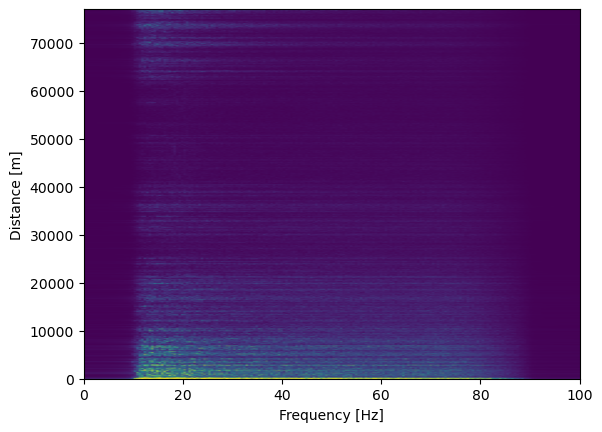

In [10]:
idx_start = int(row['t']*fs)
idx_end = int((row['t'] + 2)*fs-1)

tx_seg = tx[:, idx_start:idx_end]
fx_fullCable = np.abs(np.fft.rfft(tx_seg, axis=1))
# Plot full cable FX image
fig = plt.figure()
plt.imshow(fx_fullCable, aspect='auto', origin='upper', vmin=0, vmax=30,
           extent=[0, fs/2, 0, x_extent])
plt.xlabel('Frequency [Hz]')
plt.ylabel('Distance [m]')
plt.show()



id                                                 4277
tx_id                                               570
uid                8b9429cf-548b-4884-bd74-874dc3b469b3
f_min_hz                                      17.769613
f_max_hz                                       31.56008
x_min_m                                     10586.29435
x_max_m                                     15117.70565
t                                                   2.0
win_length_s                                        2.0
dataset                                   svalbard_full
label                                                 1
label_name                                         Bp_B
saved_timestamp                 2026-01-05 18:20:48.861
username                                         ers334
source_file                          20220822_091437.h5
Name: 4137, dtype: object


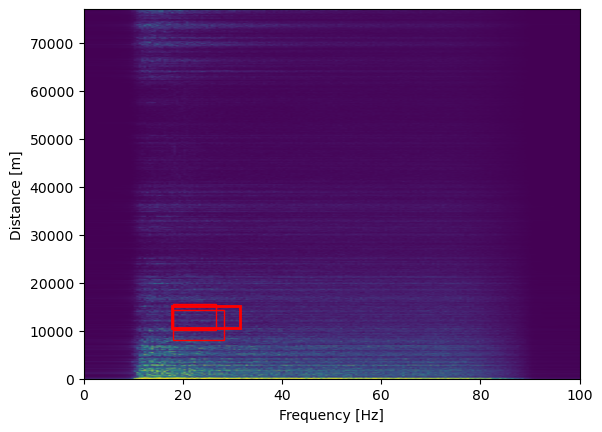

In [11]:
# add the labels
print(row)

fig = plt.figure()
plt.imshow(fx_fullCable, aspect='auto', origin='upper', vmin=0, vmax=30,
           extent=[0, fs/2, 0, x_extent])
plt.xlabel('Frequency [Hz]')
plt.ylabel('Distance [m]')
rect = plt.Rectangle(
    (row['f_min_hz'], row['x_min_m']),
    row['f_max_hz'] - row['f_min_hz'],
    row['x_max_m'] - row['x_min_m'],
    linewidth=2, edgecolor='r', facecolor='none'
    )
plt.gca().add_patch(rect)

for _, lab in same_labels.iterrows():
    rect = plt.Rectangle(
        (lab['f_min_hz'], lab['x_min_m']),
        lab['f_max_hz'] - lab['f_min_hz'],
        lab['x_max_m'] - lab['x_min_m'],
        linewidth=1, edgecolor='r', facecolor='none'
        )
    plt.gca().add_patch(rect)

plt.show()